In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

import qiskit
from qiskit.tools.visualization import circuit_drawer, plot_histogram, plot_state
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QuantumProgram
from qiskit import available_backends, execute

In [3]:
%load_ext autoreload
%autoreload 2
from utils import *

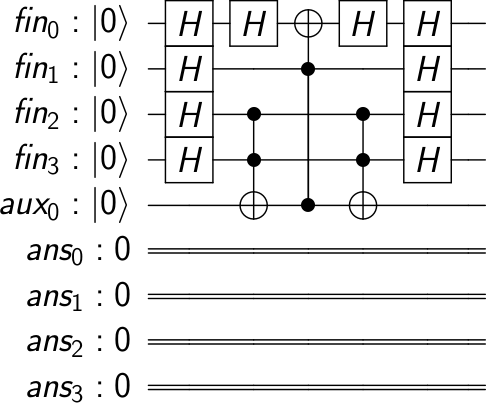

In [4]:
n = 4  # Number of qubits.
f_in = QuantumRegister(n, name='fin')
c = ClassicalRegister(n, name='ans')

target = f_in[0]
controls = [f_in[i] for i in range(1, 4)]

aux = None
qc = None
if len(controls) > 2:
    aux = QuantumRegister(len(controls) - 2, name='aux')
    qc = QuantumCircuit(f_in, aux, c, name='grover')
else:
    qc = QuantumCircuit(f_in, c, name='grover')
    
qc.h(f_in)
n_controlled_Z(qc, controls, target, aux)
qc.h(f_in)

circuit_drawer(qc)

In [5]:
n_ctl = len(controls) + 1  # Number of controls.
statevector = execute(qc, backend='local_statevector_simulator_py', shots=1).result().get_data()['statevector']
statevector = statevector[:2 ** n_ctl]
statevector

array([ 0.875-3.97216229e-16j,  0.125+2.92587421e-17j,
        0.125-1.34254504e-16j, -0.125+1.82696410e-16j,
        0.125+1.60692087e-17j, -0.125+1.82696410e-16j,
       -0.125+1.85689438e-16j,  0.125-1.76472665e-16j,
        0.125-3.55694708e-18j, -0.125+1.82696410e-16j,
       -0.125+2.05315594e-16j,  0.125-1.76472665e-16j,
       -0.125+4.16208151e-17j,  0.125-1.90350452e-16j,
        0.125-2.15113000e-16j, -0.125+1.68818622e-16j])

You can check results [here](http://algassert.com/quirk#circuit={"cols":[["H","H","H","H"],["Z","•","•","•"],["H","H","H","H"]]}).

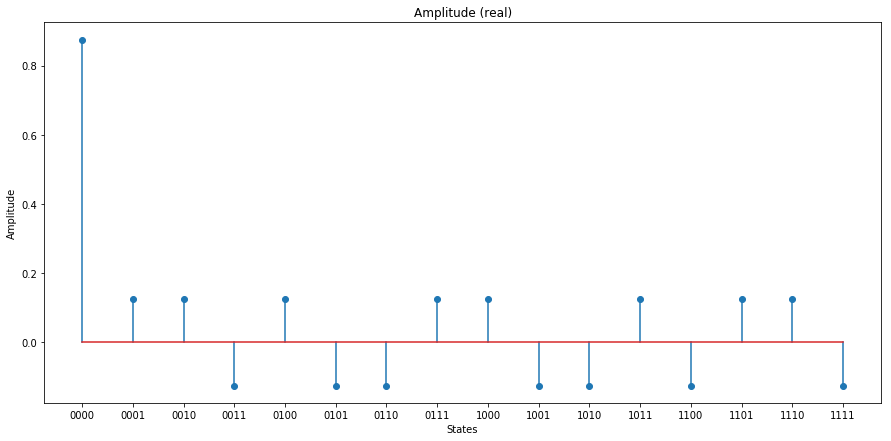

In [6]:
plt.figure(figsize=(15, 7))
x = np.arange(1, 1 + 2 ** n_ctl)
states = list(map(lambda x: ''.join(map(str, x)), itertools.product([0, 1], repeat=n_ctl)))
plt.stem(x, statevector.real)
plt.xticks(x, states)
plt.title('Amplitude (real)')
plt.xlabel('States')
plt.ylabel('Amplitude')
plt.show()

# Grover only

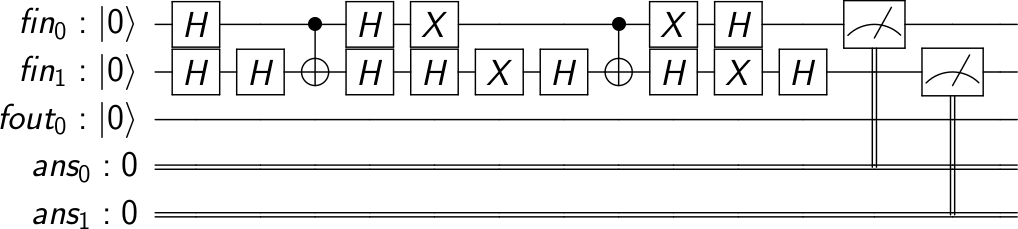

In [63]:
n = 2  # Number of qubits.

f_in = QuantumRegister(n, name='fin')
f_out = QuantumRegister(1, name='fout')
ans = ClassicalRegister(n, name='ans')

n_controls = n

aux = None
qc = None
if n_controls > 2:
    aux = QuantumRegister(n_controls - 2, name='aux')
    qc = QuantumCircuit(f_in, f_out, aux, ans, name='grover')
else:
    qc = QuantumCircuit(f_in, f_out, ans, name='grover')

qc.h(f_in)
n_controlled_Z(qc, [f_in[0]], f_in[1], aux)
inversion_about_average(qc, f_in, aux, n)

qc.measure(f_in, ans)

circuit_drawer(qc)

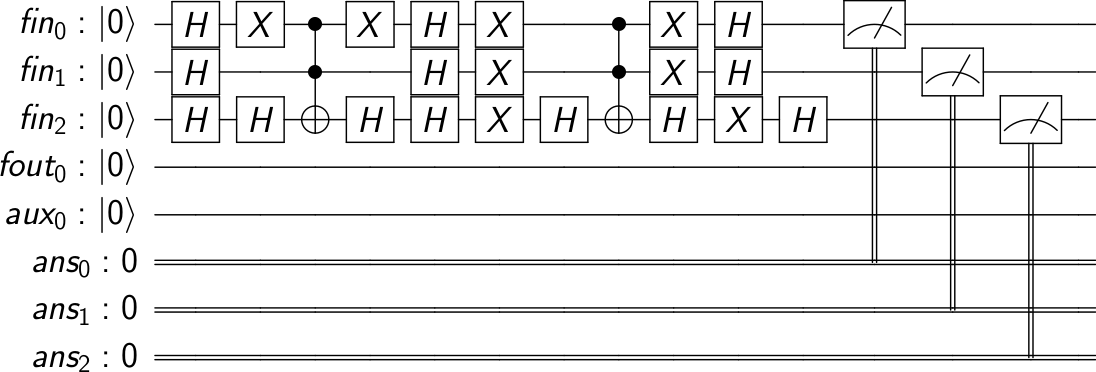

In [67]:
n = 3  # Number of qubits.

f_in = QuantumRegister(n, name='fin')
f_out = QuantumRegister(1, name='fout')
ans = ClassicalRegister(n, name='ans')

n_controls = n

aux = None
qc = None
if n_controls > 2:
    aux = QuantumRegister(n_controls - 2, name='aux')
    qc = QuantumCircuit(f_in, f_out, aux, ans, name='grover')
else:
    qc = QuantumCircuit(f_in, f_out, ans, name='grover')

qc.h(f_in)
qc.x(f_in[0])
n_controlled_Z(qc, [f_in[0], f_in[1]], f_in[2], aux)
qc.x(f_in[0])
inversion_about_average(qc, f_in, aux, n)

qc.measure(f_in, ans)

circuit_drawer(qc)

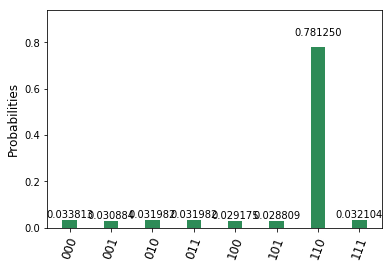

In [68]:
result = execute(qc, backend='local_qasm_simulator', shots=8192).result()
counts = result.get_counts('grover')
plot_histogram(counts)

# k-SAT

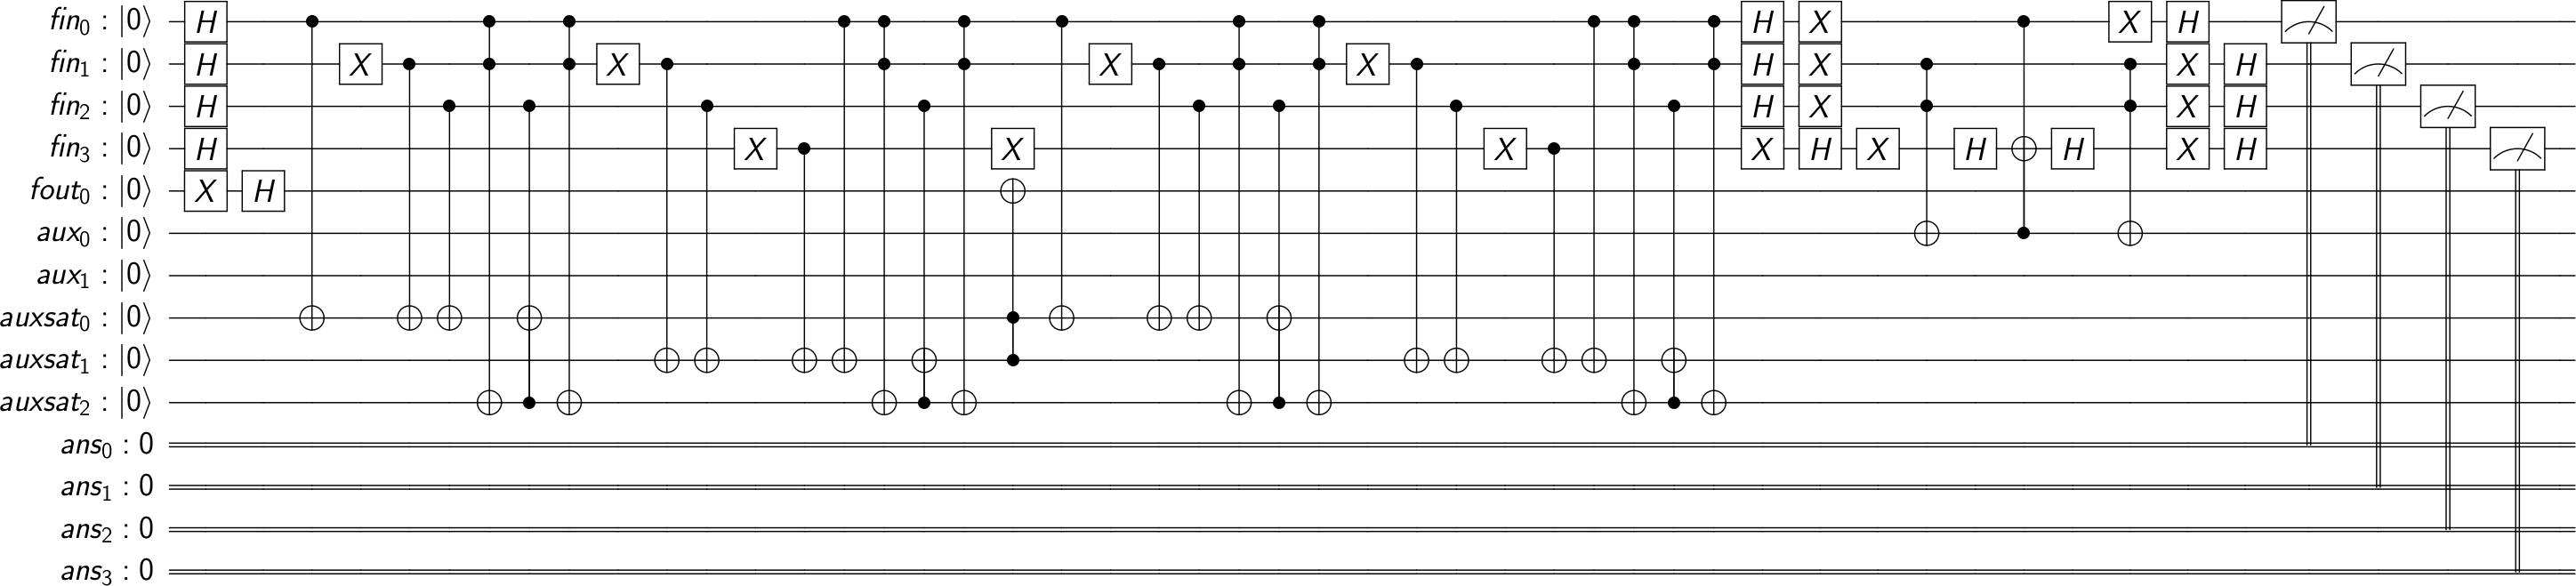

In [69]:
n = 4  # Number of qubits.
sat_formula = [[1, -2, 3], [2, 3, -4, 1]]

f_in = QuantumRegister(n, name='fin')
f_out = QuantumRegister(1, name='fout')
aux_sat = QuantumRegister(len(sat_formula) + 1, name='auxsat')
ans = ClassicalRegister(n, name='ans')

n_controls = n

aux = None
qc = None
if n_controls > 2:
    aux = QuantumRegister(n_controls - 2, name='aux')
    qc = QuantumCircuit(f_in, f_out, aux, aux_sat, ans, name='grover')
else:
    qc = QuantumCircuit(f_in, f_out, aux_sat, ans, name='grover')

input_state(qc, f_in, f_out)
black_box_u_f(qc, f_in, f_out, aux_sat, n, sat_formula)
inversion_about_average(qc, f_in, aux, n)

qc.measure(f_in, ans)

circuit_drawer(qc)

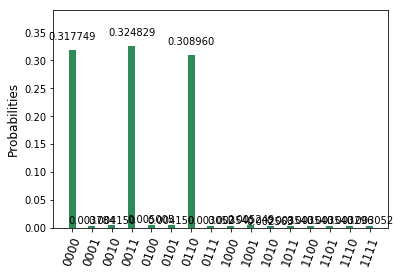

In [70]:
result = execute(qc, backend='local_qasm_simulator', shots=8192).result()
counts = result.get_counts('grover')
plot_histogram(counts)